In [1]:
import tensorflow as tf
import pandas as pd

## **Mount dataset from Google Drive**
must login to email that stores the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile,os
local_zip = '/content/drive/MyDrive/123200153_123200164_123200168(B)/Dataset Project/tanamanherbal.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/Project')
zip_ref.close()

## **Split Folder**
train 80%, validation 10%, and testing 10%

In [4]:
!pip install split-folders
import splitfolders 

splitfolders.ratio('/content/sample_data/Project/Tanaman Herbal bismillah', 
                   output="/content/sample_data/Project/Tanaman Herbal bismillah/split", seed=1337, ratio=(0.8,0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 1800 files [00:56, 31.69 files/s]


In [5]:
base_dir = '/content/sample_data/Project/Tanaman Herbal bismillah/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
check_dir = '/content/sample_data/Project/Tanaman Herbal bismillah/split/check' 
# Direktori penyimpanan data train hasil preprocessing, dibuat manual

In [6]:
print("TRAIN")
print(os.listdir('/content/sample_data/Project/Tanaman Herbal bismillah/split/train'))
print("Total Data : ", sum([len(files) for r, d, files in os.walk('/content/sample_data/Project/Tanaman Herbal bismillah/split/train')]))

print("\nVALIDATION")
print(os.listdir('/content/sample_data/Project/Tanaman Herbal bismillah/split/val'))
print("Total Data : ", sum([len(files) for r, d, files in os.walk('/content/sample_data/Project/Tanaman Herbal bismillah/split/val')]))

print("\nTEST")
print(os.listdir('/content/sample_data/Project/Tanaman Herbal bismillah/split/test'))
print("Total Data : ", sum([len(files) for r, d, files in os.walk('/content/sample_data/Project/Tanaman Herbal bismillah/split/test')]))

TRAIN
['Daun Kari', 'Daun Kemangi', 'Lidah Buaya', 'Daun Pepaya', 'Daun Sirih', 'Daun Jambu Biji']
Total Data :  1440

VALIDATION
['Daun Kari', 'Daun Kemangi', 'Lidah Buaya', 'Daun Pepaya', 'Daun Sirih', 'Daun Jambu Biji']
Total Data :  180

TEST
['Daun Kari', 'Daun Kemangi', 'Lidah Buaya', 'Daun Pepaya', 'Daun Sirih', 'Daun Jambu Biji']
Total Data :  180


## **Preprocessing**
Multiply the amount of data with data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical',
        save_to_dir=check_dir) # Menyimpan hasil preprocessing train data ke direktori khusus

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4, 
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4, 
        class_mode='categorical')

Found 1440 images belonging to 6 classes.
Found 180 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [12]:
# Menyimpan 1 per 1 image hasil preprocessing dari data train
for i in range(len(train_generator)):
  x,y = next(train_generator)

In [13]:
test_generator.class_indices
# Cek kelas untuk prediksi di akhir

{'Daun Jambu Biji': 0,
 'Daun Kari': 1,
 'Daun Kemangi': 2,
 'Daun Pepaya': 3,
 'Daun Sirih': 4,
 'Lidah Buaya': 5}

## **Modeling**
Sequential model Convolutional Neural Network (CNN)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [19]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAkurasi di atas 97%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

# **Build Model between Train - Validation**
Fitting model between train data and validation data

In [20]:
history = model.fit(
            train_generator,
            steps_per_epoch=90, # 1440 images, batch_size * steps = jml_gambar -- 1 batch_size = 16 citra
            epochs=30,
            validation_data=validation_generator,
            validation_steps=11, # 876 images
            verbose=2,
            callbacks=[callbacks])

Epoch 1/30
90/90 - 224s - loss: 1.6107 - accuracy: 0.3528 - val_loss: 1.5937 - val_accuracy: 0.4773 - 224s/epoch - 2s/step
Epoch 2/30
90/90 - 203s - loss: 0.9126 - accuracy: 0.6500 - val_loss: 0.6605 - val_accuracy: 0.7500 - 203s/epoch - 2s/step
Epoch 3/30
90/90 - 201s - loss: 0.7534 - accuracy: 0.7194 - val_loss: 0.8807 - val_accuracy: 0.7045 - 201s/epoch - 2s/step
Epoch 4/30
90/90 - 215s - loss: 0.7529 - accuracy: 0.7194 - val_loss: 0.7505 - val_accuracy: 0.8409 - 215s/epoch - 2s/step
Epoch 5/30
90/90 - 205s - loss: 0.6318 - accuracy: 0.7611 - val_loss: 0.4396 - val_accuracy: 0.8864 - 205s/epoch - 2s/step
Epoch 6/30
90/90 - 205s - loss: 0.5096 - accuracy: 0.8250 - val_loss: 0.2046 - val_accuracy: 0.9091 - 205s/epoch - 2s/step
Epoch 7/30
90/90 - 203s - loss: 0.5944 - accuracy: 0.7417 - val_loss: 0.3755 - val_accuracy: 0.8409 - 203s/epoch - 2s/step
Epoch 8/30
90/90 - 223s - loss: 0.4075 - accuracy: 0.8472 - val_loss: 0.3510 - val_accuracy: 0.8636 - 223s/epoch - 2s/step
Epoch 9/30
90/90

# **Loss and Accuracy between Train - Validation**
Calculate the value of loss and accuracy of model (Train - Validation)

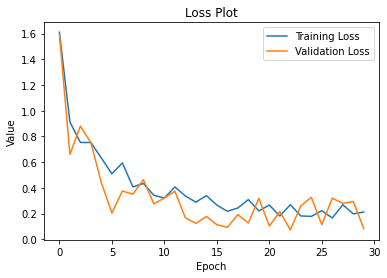

In [21]:
from matplotlib import pyplot as plt
# Loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

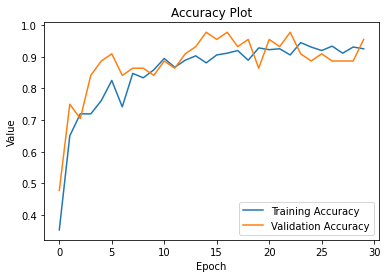

In [22]:
# Accuracy train & validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# **Build Model between Train - Test**
Fitting model between train data and test data

In [23]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=90,
    epochs=10,
    validation_data=test_generator,
    validation_steps=11,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/10
90/90 - 232s - loss: 0.1788 - accuracy: 0.9444 - val_loss: 0.2044 - val_accuracy: 0.9318 - 232s/epoch - 3s/step
Epoch 2/10
90/90 - 203s - loss: 0.2189 - accuracy: 0.9278 - val_loss: 0.1667 - val_accuracy: 0.9091 - 203s/epoch - 2s/step
Epoch 3/10
90/90 - 223s - loss: 0.2481 - accuracy: 0.9028 - val_loss: 0.1932 - val_accuracy: 0.9318 - 223s/epoch - 2s/step
Epoch 4/10
90/90 - 209s - loss: 0.1933 - accuracy: 0.9389 - val_loss: 0.3905 - val_accuracy: 0.8864 - 209s/epoch - 2s/step
Epoch 5/10
90/90 - 201s - loss: 0.2104 - accuracy: 0.9333 - val_loss: 0.1677 - val_accuracy: 0.9773 - 201s/epoch - 2s/step
Epoch 6/10
90/90 - 206s - loss: 0.1273 - accuracy: 0.9472 - val_loss: 0.0906 - val_accuracy: 0.9773 - 206s/epoch - 2s/step
Epoch 7/10
90/90 - 208s - loss: 0.2108 - accuracy: 0.9222 - val_loss: 0.0894 - val_accuracy: 0.9773 - 208s/epoch - 2s/step
Epoch 8/10
90/90 - 203s - loss: 0.1172 - accuracy: 0.9556 - val_loss: 0.0614 - val_accuracy: 0.9773 - 203s/epoch - 2s/step
Epoch 9/10
90/90

# **Loss and Accuracy between Train - Test**
Calculate the value of loss and accuracy of model (Train - Test)

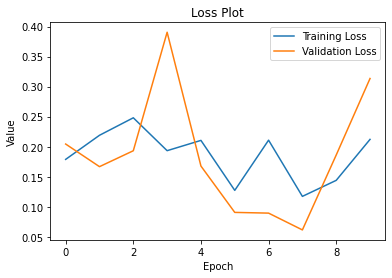

In [26]:
from matplotlib import pyplot as plt
# Loss train & test
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

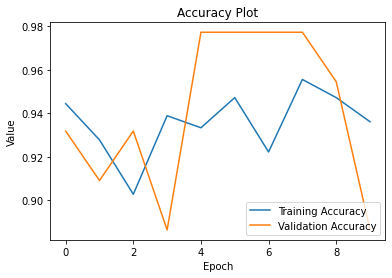

In [27]:
# Accuracy train & test
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

Saving test kari (1).JPG to test kari (1).JPG
1/1 [==============================] - 1s 643ms/step
test kari (1).JPG
DAUN KARI


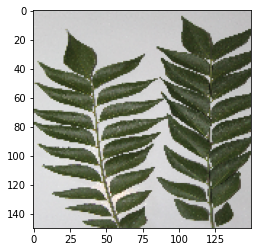

In [28]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(fn)
  if output_class==0:
      print('DAUN JAMBU BIJI')
  elif output_class==1:
      print('DAUN KARI')
  elif output_class==2:
      print('DAUN KEMANGI')
  elif output_class==3:
      print('DAUN PEPAYA')
  elif output_class==4:
      print('DAUN SIRIH')
  else:
      print('DAUN LIDAH BUAYA')